In [28]:
# Librerias
import os
from bs4 import BeautifulSoup
from unidecode import unidecode
import datetime
import traceback
import json
import csv
import pandas as pd
import jellyfish
from collections import OrderedDict
import matplotlib
import matplotlib.pyplot as plt

In [29]:
# Parámetros
sourceDataFolder = "1-input"

emailsRootPath = sourceDataFolder + r"\support\email"
covidRootPath = sourceDataFolder + r"\support\covid"
gysAdRootPath = sourceDataFolder + r"\support\gys-ad"
azureAdRootPath = sourceDataFolder + r"\support\azure-ad"
inHomeRootPath = sourceDataFolder + r"\support\in-home"
mainRootPath = sourceDataFolder + r"\main"
supportRootPath = sourceDataFolder + r"\support"
mastersRootPath = sourceDataFolder + r"\masters"

intermFilesFolder = "2-process"
mainFolder = intermFilesFolder + r"\main"
supportFolder = intermFilesFolder + r"\support"

resultsFolder = "3-output"
otherOutputFolder = "../3-modelling/1-input/"

logsFolder = "4-logs"

dataVisualizationTopLimit = 20

counterIn = 0
counterOut = 0

In [30]:
# Funciones utilitarias
def find_nth(haystack, needle, n):
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start+len(needle))
        n -= 1
    return start

def parseLineBreaksAndAccents(text):
  return unidecode(" ".join(text.split()))

def parseNames(text):
  return text.strip().title()

def findTags(tag, color):
  return tag.find("span", {"style": 'font-size:10.0pt;font-family:"Arial",sans-serif;mso-fareast-font-family:\n"Times New Roman";color:' + color })

def getChildIndex(mainChildTags, title, color):
  return next((index for index, tag in enumerate(mainChildTags) if ( findTags(tag, color).text == title if findTags(tag, color) else False )), None)

def getSectionsIndexes(mainChildTags, color):
  sectionsIndexes = []
  sectionsTitle = ["Experiencia laboral", "Educación", "Informática", "Idiomas", "Otros Conocimientos"]
  
  for sectionTitle in sectionsTitle:
    sectionIndex = getChildIndex(mainChildTags, sectionTitle, color)
    sectionsIndexes.append(sectionIndex)
  
  sectionsIndexes.append(len(mainChildTags)-1)
  return sectionsIndexes

def getNextSectionIndexValid(sectionsIndexes, i):
  while(not sectionsIndexes[i]):
    i = i + 1

  return sectionsIndexes[i]

def readJson(path, encoding='utf-8', errors=None):
  with open (path, "r", encoding=encoding, errors=errors) as f:
    data = json.loads(f.read())
  return data

def writeJson(data, pathJson, encoding='utf-8'):
  with open(pathJson, 'w', encoding=encoding) as f:
    json.dump(data, f, indent=4, ensure_ascii=False)

def writeCsv(data, pathCsv, encoding='utf-8'):
  with open(pathCsv, 'w', newline='', encoding=encoding) as f:
    if data:
      writer = csv.DictWriter(f, fieldnames=data[0].keys(), lineterminator='\n')
      writer.writeheader()
      writer.writerows(data)
    else:
      f.write("")

def writeTxt(data, pathTxt, encoding='utf-8'):
  with open(pathTxt, 'w', encoding=encoding) as f:
    f.write(data)

def readSupport(file, readEncoding = 'utf-8'):
  with open(os.path.join(file), "r", encoding=readEncoding) as file:
    data = [{k: parseNames(v) for k, v in row.items()} for row in csv.DictReader(file, skipinitialspace=True)]

  return data

def readAndWriteSupport(folder, file, writeFileName, readEncoding = 'utf-8', writeEncoding = 'utf-8'):
  with open(os.path.join(folder, file), "r", encoding=readEncoding) as file:
    data = [{k: parseNames(v) for k, v in row.items()} for row in csv.DictReader(file, skipinitialspace=True)]

  with open(os.path.join(supportFolder, writeFileName), 'w', encoding=writeEncoding) as file:
    json.dump(data, file, indent=4, ensure_ascii=False)
  
  return data

def getCompare(data, fields):
  return (list(set([" ".join(x for x in [elem[y] for y in fields] if x) for elem in data if elem])))

In [31]:
def readAndWriteInHome(folder, writeFileName):
  folderFiles = [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

  attendees = []
  
  for file in folderFiles:
    # Detectar si tienen el To: en el texto
    try:
      # Detectar el encoding
      encoding = "utf-16"
      with open(file, "r") as f:
        encoding = 'windows-1252' if "charset=windows-1252" in f.read() else 'utf-16'

      # El .read() manda el cursor al final del archivo, por eso si se usa 2 veces, la 2da vez no encuentra nada
      with open(file, "r", encoding=encoding) as f:
        soup = BeautifulSoup(f.read(), "lxml")
        #print(str(soup))
        # El soup.text le quita las etiquetas
        if '<span style="color:black">To:<span style="mso-tab-count:1">' in parseLineBreaksAndAccents(str(soup)):
          allAttendees = parseLineBreaksAndAccents(soup.find_all("span", {"style": 'color:black'})[5].text)
          attendeesList = allAttendees.split("; ")
          attendees.extend(attendeesList)
    except Exception as e:
      print(file)
      traceback.print_exc()
      print()
      pass

  data = [ {"name": parseNames(participant)} for participant in attendees ]

  with open(os.path.join(supportFolder, writeFileName), 'w', encoding='utf-8') as file:
    json.dump(data, file, indent=4, ensure_ascii=False)

  return data

In [32]:
def readAndWriteTaggedData(preprocessedData, emailsData, covidData, gysAdData, azureAdData, inHomeData):
  # Definiendo arrays con el nombre
  arrayNames = [
    getCompare(emailsData, ["nombreParaMostrar"]),
    getCompare(emailsData, ["primerNombre", "apellidoPaterno"]),
    getCompare(emailsData, ["segundoNombre", "apellidoPaterno"]),
    getCompare(emailsData, ["primerNombre", "apellidoPaterno", "apellidoMaterno"]),
    getCompare(emailsData, ["segundoNombre", "apellidoPaterno", "apellidoMaterno"]),
    getCompare(emailsData, ["primerNombre", "segundoNombre", "apellidoPaterno", "apellidoMaterno"]),
    getCompare(covidData, ["nombreParaMostrar"]),
    getCompare(covidData, ["primerNombre", "apellidoPaterno"]),
    getCompare(covidData, ["segundoNombre", "apellidoPaterno"]),
    getCompare(covidData, ["primerNombre", "apellidoPaterno", "apellidoMaterno"]),
    getCompare(covidData, ["segundoNombre", "apellidoPaterno", "apellidoMaterno"]),
    getCompare(covidData, ["primerNombre", "segundoNombre", "apellidoPaterno", "apellidoMaterno"]),
    getCompare(gysAdData, ["Nombre para mostrar"]),
    getCompare(gysAdData, ["Nombre", "Apellido"]),
    getCompare(azureAdData, ["displayName"]),
    getCompare(azureAdData, ["givenName", "surname"]),
    getCompare(inHomeData, ["name"]),
  ]

  # Leyendo la data de contratados
  sensitivity = 0.85

  for index, row in enumerate(preprocessedData):
    if (index % 500 == 0):
      print(str(index) + "/" + str(len(preprocessedData)) + " registros analizados")
    for arrayName in arrayNames:
      for elem in arrayName:
        distance = jellyfish.jaro_distance(row["candidateFullName"], elem)
        if (distance > sensitivity):
          row["hired"] = 1
          break
      if "hired" not in row:
        row["hired"] = 0
  
  writeJson(preprocessedData, os.path.join(mainFolder, 'result.json'), 'utf-8')
  writeCsv(preprocessedData, os.path.join(mainFolder, 'result.csv'), 'utf-8')

  return preprocessedData


In [33]:
def readAndWritePreprocessedData(mergedMainData, masters):
  """# Añadiendo los nuevos campos del puesto de trabajo
  for elem in mergedMainData:
    for elem2 in masters[0]:
      if elem["profileName"] == elem2["profileName"]:
        elem["profileName"] = elem2["equivalence"]

  # Añadiendo los nuevos campos del ultimo trabajo
  for elem in mergedMainData:
    for elem2 in masters[1]:
      if elem["lastWorkCenter"] == elem2["lastWorkCenter"]:
        elem["lastWorkCenter"] = elem2["equivalence"]

  # Añadiendo los nuevos campos de la ultima posición
  for elem in mergedMainData:
    for elem2 in masters[2]:
      if elem["lastWorkPosition"] == elem2["lastWorkPosition"]:
        elem["lastWorkPosition"] = elem2["equivalence"]

  # Añadiendo los nuevos campos del ultimo trabajo
  for elem in mergedMainData:
    for elem2 in masters[3]:
      if elem["studyCenter"] == elem2["studyCenter"]:
        elem["studyCenter"] = elem2["equivalence"]"""
  

  # Eliminando atributos que no se usarán
  notIncluded = [
    "candidatePostulationDate", "jobId", "candidateFullName", "candidateDocumentNumber", "candidateBirthDate", "candidateAddress", "candidateHomeNumber", "candidateCellphoneNumber", "candidateEmail", "workObjetive", "lastWorkDescription"
  ]
  mergedMainData = [{key:value for key, value in elem.items() if key not in notIncluded} for elem in mergedMainData]

  writeJson(mergedMainData, os.path.join(resultsFolder, 'result.json'), 'utf-8')
  writeCsv(mergedMainData, os.path.join(resultsFolder, 'result.csv'), 'utf-8')

  writeJson(mergedMainData, os.path.join(otherOutputFolder, 'result.json'), 'utf-8')
  writeCsv(mergedMainData, os.path.join(otherOutputFolder, 'result.csv'), 'utf-8')

  return mergedMainData

In [34]:
def visualizeData(mergedMainData):
  df = pd.DataFrame(mergedMainData)

  print()

  columns = [elem for elem in df.columns if elem not in ["candidatePostulationDate", "candidateFullName"]] 

  for column in columns:
    groupedData = df[column].value_counts()
    print("Total de valores diferentes: " + str(len(groupedData)))
    top10 = groupedData[:dataVisualizationTopLimit]
    print(top10)
    y_axis = list(reversed(top10.index))
    x_axis = list(reversed(top10.values))
    plt.ylabel(column)
    plt.barh(y_axis, x_axis)
    plt.show()

In [35]:
def main():
  # Definiendo el inicio del proceso
  startTime = datetime.datetime.now()
  print("Inicio: " + str(startTime))
  print("Se inició el procesamiento")

  # Leyendo la data obtenida en el entendimiento de los datos
  mergedMainData = readJson(os.path.join(mainRootPath, 'result.json'))

  # Definiendo variables booleanas para leer o leer y procesar los archivos de apoyo
  isLoadedEmailData = True
  isLoadedCovidData = True
  isLoadedGysAdData = True
  isLoadedAzureAdData = True
  isLoadedInHomeData = True
  isTaggedData = True
  isPreprocessed = False

  # Leyendo el archivo de correos
  emailsData = readJson(os.path.join(supportFolder, 'email.json')) if isLoadedEmailData else readAndWriteSupport(emailsRootPath, 'email.csv', 'email.json', 'windows-1252')
  print("Se terminó de procesar email")

  # Leyendo el archivo de covid
  covidData = readJson(os.path.join(supportFolder, 'covid.json')) if isLoadedCovidData else readAndWriteSupport(covidRootPath, 'covid.csv', 'covid.json', 'windows-1252')
  print("Se terminó de procesar covid")

  # Leyendo el archivo de gys AD
  gysAdData = readJson(os.path.join(supportFolder, 'gys-ad.json')) if isLoadedGysAdData else readAndWriteSupport(gysAdRootPath, 'gys-ad.csv', 'gys-ad.json', readEncoding='utf-8-sig')
  print("Se terminó de procesar gysAd")

  # Leyendo el archivo de azure AD
  azureAdData = readJson(os.path.join(supportFolder, 'azure-ad.json')) if isLoadedAzureAdData else readAndWriteSupport(azureAdRootPath, 'azure-ad.csv', 'azure-ad.json', readEncoding='utf-8-sig')
  print("Se terminó de procesar azureAd")

  # Leyendo el archivo de inHome
  inHomeData = readJson(os.path.join(supportFolder, 'in-home.json')) if isLoadedInHomeData else readAndWriteInHome(inHomeRootPath, 'in-home.json')
  print("Se terminó de procesar inHome")

  # Asignando la variable objetivo
  taggedData = readJson(os.path.join(mainFolder, 'result.json')) if isTaggedData else readAndWriteTaggedData(mergedMainData, emailsData, covidData, gysAdData, azureAdData, inHomeData)
  print("Se terminó de procesar la data final")

  # Preprocesamiento de datos
  # Leyendo archivos maestros
  profileNameMaster = readSupport(os.path.join(mastersRootPath, 'profileName.csv'))
  lastWorkCenterMaster = readSupport(os.path.join(mastersRootPath, 'lastWorkCenter.csv'))
  lastWorkPositionMaster = readSupport(os.path.join(mastersRootPath, 'lastWorkPosition.csv'))
  studyCenterMasterMaster = readSupport(os.path.join(mastersRootPath, 'studyCenter.csv'))

  # Aplicando los datos de los maestros y validaciones
  preprocessedData = readJson(os.path.join(resultsFolder, 'result.json')) if isPreprocessed else readAndWritePreprocessedData(taggedData, [profileNameMaster, lastWorkCenterMaster, lastWorkPositionMaster, studyCenterMasterMaster])
  print("Se terminó el preprocesamiento")

  visualizeData(preprocessedData)

  # Definiendo el fin del proceso
  endTime = datetime.datetime.now()
  print("Fin: " + str(endTime))
  print("Tiempo: " + str(endTime-startTime))

Inicio: 2023-05-20 14:14:35.343670
Se inició el procesamiento
Se terminó de procesar email
Se terminó de procesar covid
Se terminó de procesar gysAd
Se terminó de procesar azureAd
Se terminó de procesar inHome
Se terminó de procesar la data final
Se terminó el preprocesamiento

Total de valores diferentes: 170
Practicante De Recursos Humanos                    942
Ejecutivo Comercial                                430
Analista Funcional                                 368
Gestor De Servicios De Ti                          356
Asistente De Recursos Humanos                      354
Jefe De Proyecto - Analytics & Ai                  293
Asistente Social                                   283
Practicante De Infrastructure & Cloud              278
Programador .Net                                   269
Analista Programador                               252
Asistente De Pmo                                   243
Community Manger                                   184
Desarrollador .Net          

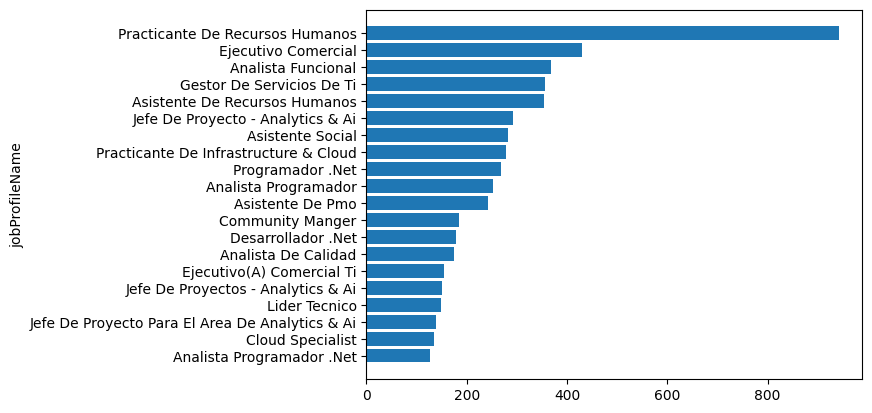

Total de valores diferentes: 15
Peru                    9856
Venezuela                144
                          63
Argentina                 11
Colombia                   9
Brasil                     4
Ecuador                    3
Republica Dominicana       2
Chile                      2
Bolivia                    1
Francia                    1
Costa Rica                 1
Espana                     1
Panama                     1
El Salvador                1
Name: candidateResidenceCountry, dtype: int64


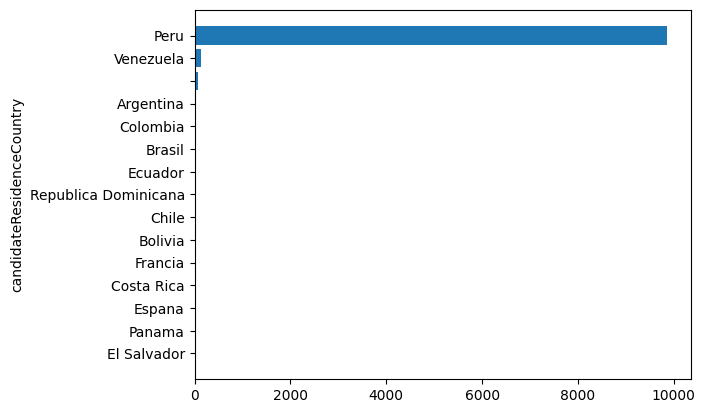

Total de valores diferentes: 7
Soltero/A          7738
Casado/A           1468
                    614
Divorciado/A        124
Pareja De Hecho     108
Union Libre          45
Viudo/A               3
Name: candidateCivilStatus, dtype: int64


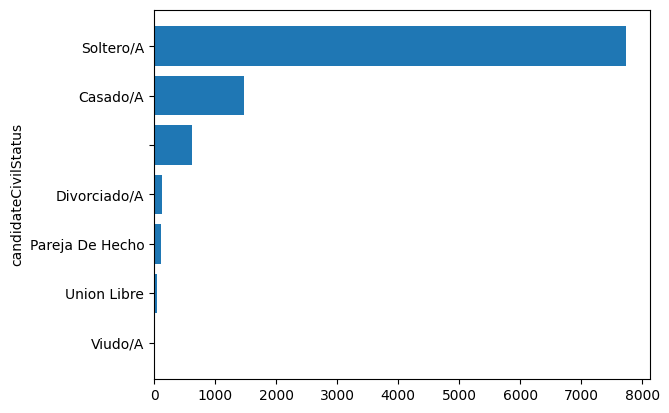

Total de valores diferentes: 15
Peru                    9856
Venezuela                144
                          63
Argentina                 11
Colombia                   9
Brasil                     4
Ecuador                    3
Republica Dominicana       2
Chile                      2
Bolivia                    1
Francia                    1
Costa Rica                 1
Espana                     1
Panama                     1
El Salvador                1
Name: candidateBirthCountry, dtype: int64


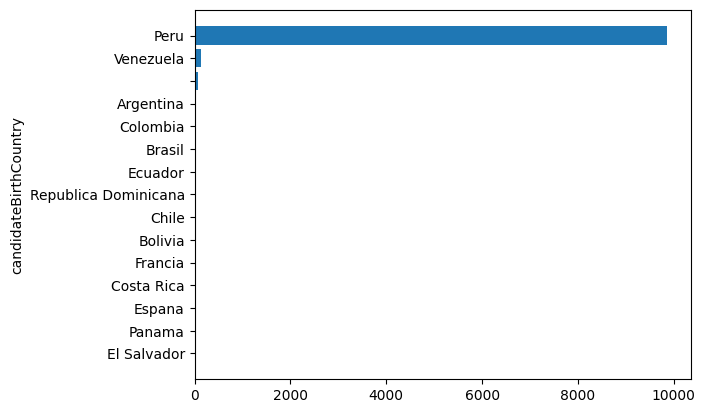

Total de valores diferentes: 183
5000    610
2500    604
2000    581
3500    555
3000    543
4000    520
1500    466
6000    436
0       421
4500    400
1200    357
1800    354
1025    296
5500    296
1000    279
7000    278
6500    277
930     220
8000    201
1       199
Name: salary, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_12644\2838785334.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top10 = groupedData[:dataVisualizationTopLimit]


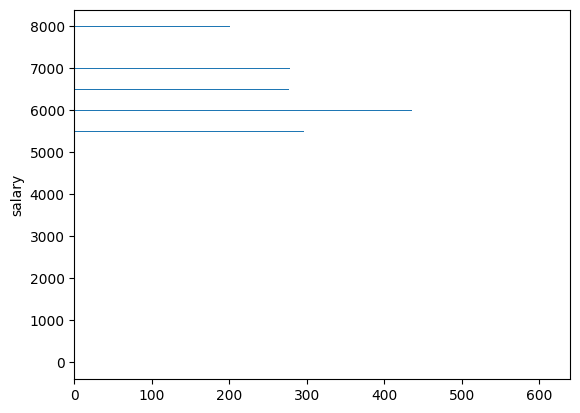

Total de valores diferentes: 1919
0      589
61     158
153    152
92     150
122    146
365    133
184    101
31      88
212     87
214     82
91      81
181     80
334     79
151     79
273     74
183     69
59      64
275     64
366     63
243     58
Name: lastWorkDays, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_12644\2838785334.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top10 = groupedData[:dataVisualizationTopLimit]


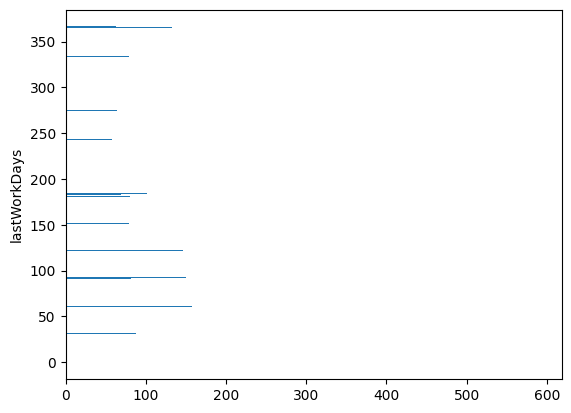

Total de valores diferentes: 5342
                                            558
Canvia                                      132
Freelance (Clientes)                         78
Global Hitss                                 69
Everis                                       56
Independiente                                55
Mdp Consulting                               52
Indra                                        48
Tata Consultancy Services                    38
Banco De Credito Del Peru                    38
Everis Peru Sac                              33
Pontificia Universidad Catolica Del Peru     26
Panacea Consultores S.A.                     26
Experis                                      25
Everis Peru                                  24
Tgestiona                                    24
Onpe                                         23
Mdp                                          22
Telefonica Del Peru                          22
Freelance                                    22
Name: 

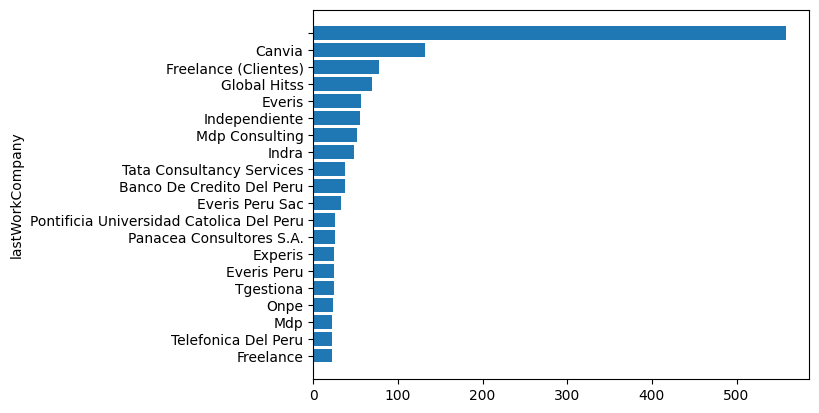

Total de valores diferentes: 32
Peru              9367
                   558
Estados Unidos      31
Venezuela           25
Espana              23
Colombia            17
Brasil              16
Chile               12
Argentina            7
Ecuador              7
Mexico               4
Albania              3
Reino Unido          3
Costa Rica           3
Finlandia            2
Australia            2
Francia              2
Italia               2
Paises Bajos         2
Panama               2
Name: lastWorkCountry, dtype: int64


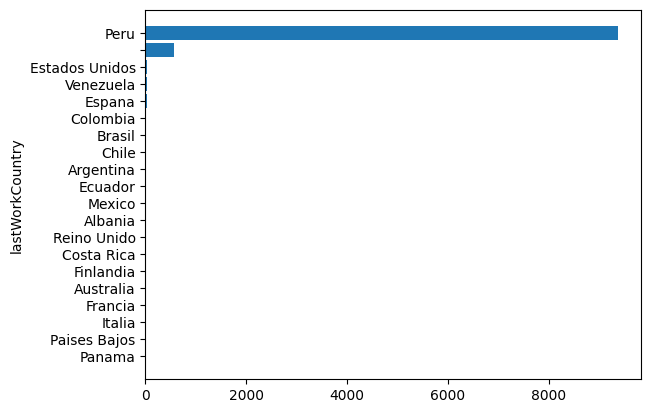

Total de valores diferentes: 153
Tecnologia / Sistemas            1038
Tecnologias De La Informacion    1020
Liderazgo De Proyecto             585
Programacion                      577
                                  558
Comercial                         538
Sistemas                          487
Recursos Humanos                  430
Ventas                            261
Administracion                    256
Analisis De Datos                 235
Analisis Funcional                221
Infraestructura                   214
Soporte Tecnico                   192
Atencion Al Cliente               162
Seguridad Informatica             156
Otras Ingenierias                 151
Desarrollo De Negocios            131
Testing / Qa / Qc                 128
Administracion De Personal        115
Name: lastWorkArea, dtype: int64


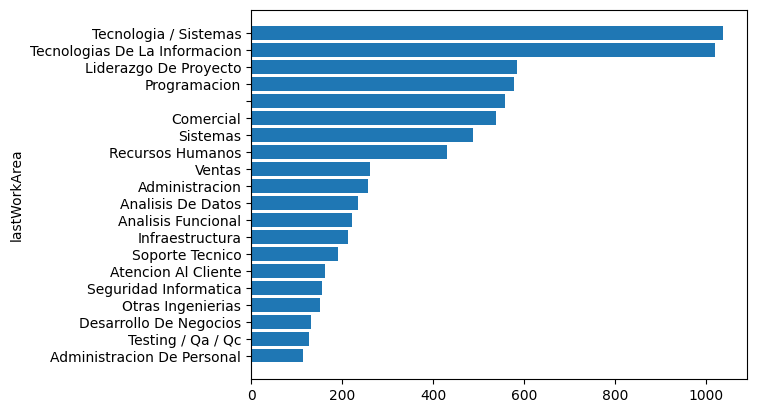

Total de valores diferentes: 4230
                                                558
Analista Programador                            393
Analista De Sistemas                            190
Analista Funcional                              119
Jefe De Proyectos                                83
Trabajadora Social                               80
Supervisor De Infraestructura De Redes Cisco     78
Asistente Administrativo                         69
Project Manager                                  54
Asesor Comercial                                 54
Practicante                                      51
Ejecutivo Comercial                              49
Asistente De Recursos Humanos                    49
Analista                                         49
Analista De Sistemas Senior                      47
Programador                                      38
Key Account Manager                              38
Jefe De Sistemas                                 37
Lider Tecnico                 

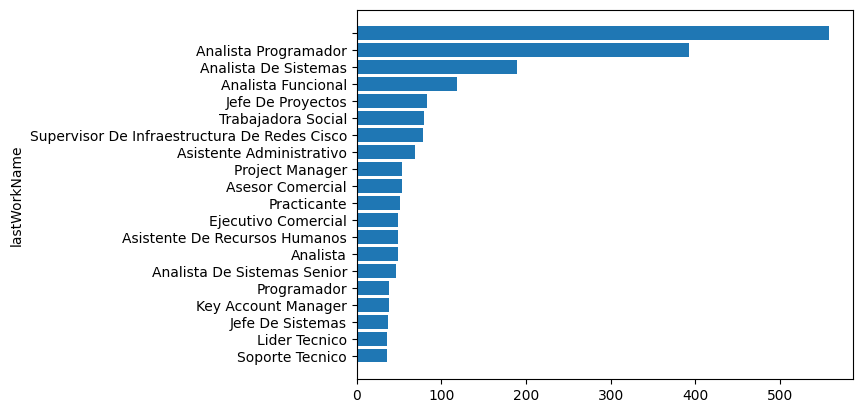

Total de valores diferentes: 54
0     1149
4      731
5      690
8      673
7      661
6      648
2      642
1      635
3      619
9      529
10     495
11     422
12     305
13     303
15     255
14     246
16     174
17     127
19     110
18     104
Name: yearsOfExperience, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_12644\2838785334.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top10 = groupedData[:dataVisualizationTopLimit]


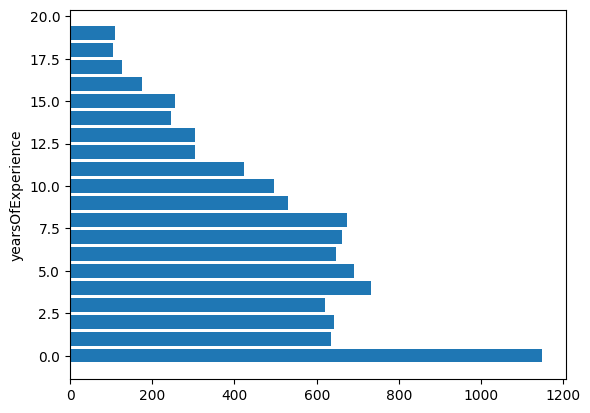

Total de valores diferentes: 29
5     1284
4     1176
6     1039
3     1008
7      926
8      729
2      728
1      650
0      558
9      523
10     405
11     271
12     238
13     148
14     118
15      90
17      59
16      45
19      35
18      29
Name: worksNumber, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_12644\2838785334.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top10 = groupedData[:dataVisualizationTopLimit]


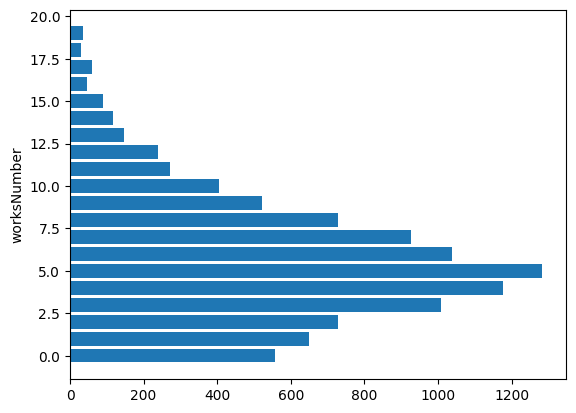

Total de valores diferentes: 2128
0       689
31      307
61      229
30      204
1736    196
92      153
1705    137
122     135
1948    126
153     120
2101    102
1795     99
91       87
1826     80
183      65
1157     63
1218     61
1675     60
123      59
1096     59
Name: lastEducationDays, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_12644\2838785334.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top10 = groupedData[:dataVisualizationTopLimit]


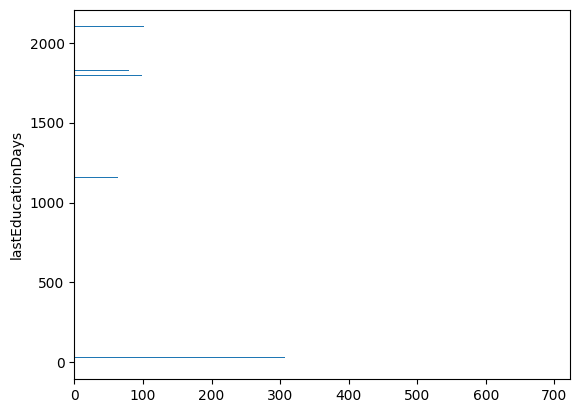

Total de valores diferentes: 1482
Universidad Peruana De Ciencias Aplicadas    564
Universidad Tecnologica Del Peru             346
Pontificia Universidad Catolica Del Peru     327
Universidad Nacional Mayor De San Marcos     300
Upc                                          294
Universidad Privada Del Norte                293
Universidad Esan                             236
Universidad De Lima                          219
Universidad Cesar Vallejo                    219
Cibertec                                     212
Instituto Cibertec                           200
Universidad Nacional De Ingenieria           197
Universidad De San Martin De Porres          187
Universidad Ricardo Palma                    179
Universidad Nacional Federico Villarreal     177
Universidad Inca Garcilaso De La Vega        168
Isil                                         168
Utp                                          159
Universidad San Ignacio De Loyola            137
                                   

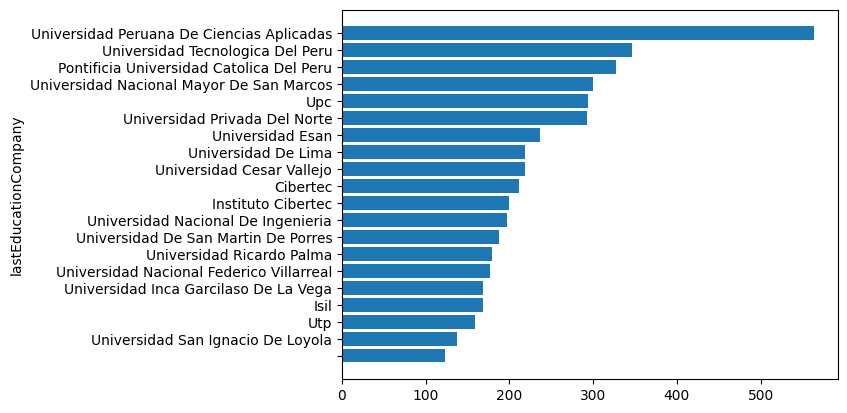

Total de valores diferentes: 29
Peru              9369
Espana             196
Venezuela          162
                   123
Estados Unidos      77
Mexico              34
Argentina           20
Colombia            19
Brasil              18
Chile               18
Costa Rica          14
Canada               8
Bolivia              6
Ecuador              6
Australia            5
Francia              5
India                3
Alemania             3
Cuba                 2
Internacional        2
Name: lastEducationCountry, dtype: int64


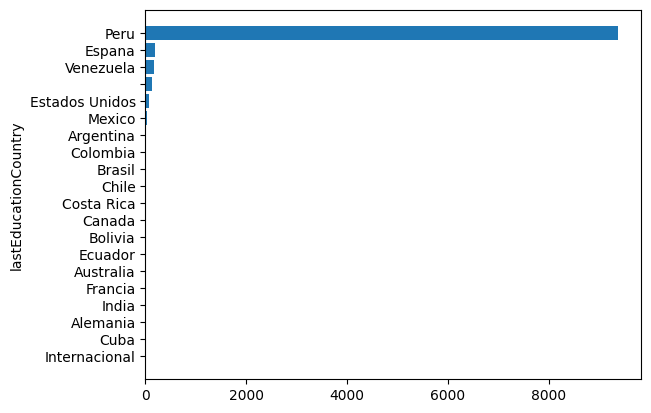

Total de valores diferentes: 106
Ing. En Sistemas                  2300
Tecnologias De La Informacion     1225
Adm. De Empresas                  1132
Ing. Informatica                   612
Ing. Industrial                    489
Computacion / Informatica          475
Marketing / Comercializacion       367
Recursos Humanos / Relac. Ind.     354
Psicologia                         347
Otra                               339
Ing. - Otros                       191
Trabajo Social                     142
Analisis De Sistemas               138
Ing. Telecomunicaciones            130
                                   123
Programacion                       122
Telecomunicaciones                 118
Procesos / Calidad Total           104
Finanzas                            95
Bachiller                           91
Name: lastEducationArea, dtype: int64


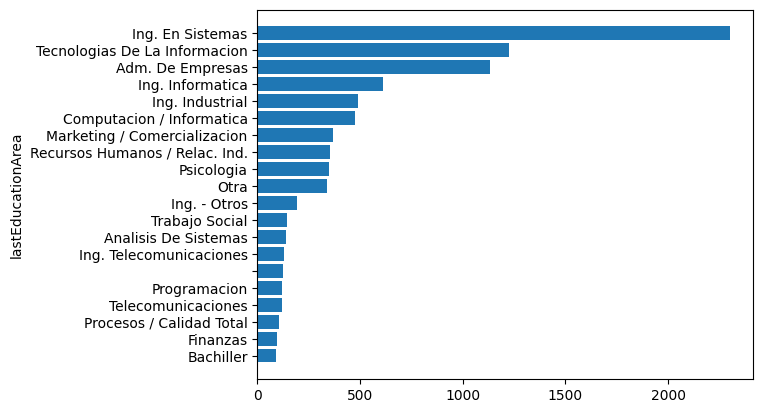

Total de valores diferentes: 3369
Ingenieria De Sistemas                       776
Ingenieria Industrial                        268
Psicologia                                   244
Administracion De Empresas                   193
Ingeniero De Sistemas                        181
Computacion E Informatica                    165
Ingenieria De Sistemas E Informatica         150
Administracion                               124
                                             123
Bachiller En Ingenieria De Sistemas           90
Trabajo Social                                67
Mba                                           62
Ingenieria De Redes Y Comunicaciones          61
Ingenieria Informatica                        60
Administracion Y Negocios Internacionales     54
Ingles                                        54
Ingenieria De Software                        54
Marketing                                     51
Ingenieria De Computacion Y Sistemas          49
Ingenieria De Sistemas De Informaci

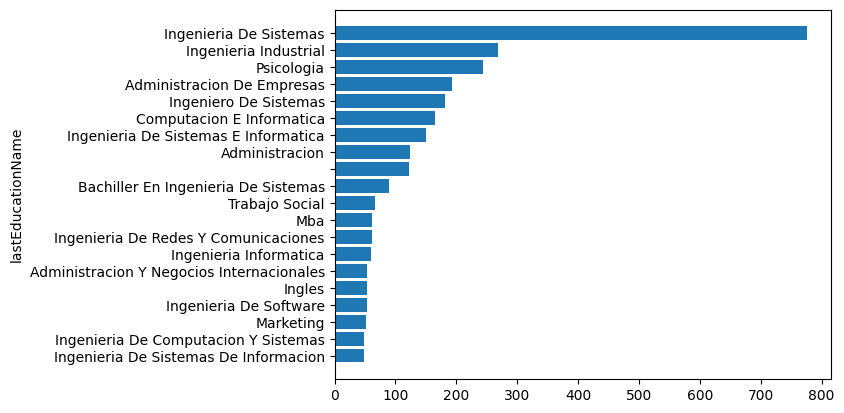

Total de valores diferentes: 4
Graduado      6527
En Curso      3292
Abandonado     157
               124
Name: lastEducationStatus, dtype: int64


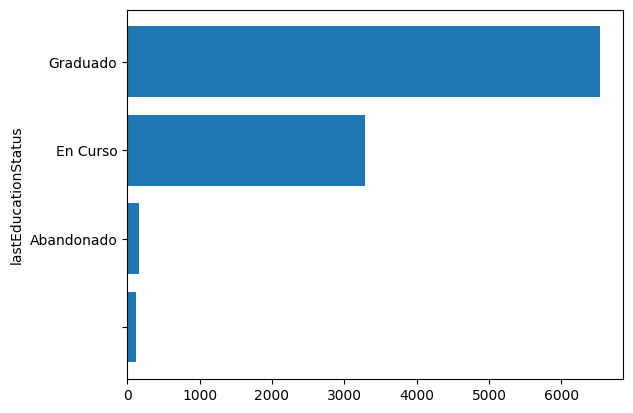

Total de valores diferentes: 8
Universitario        4965
Otro                 2237
Posgrado             1171
Terciario/Tecnico     978
Master                602
                      123
Doctorado              13
Secundario             11
Name: lastEducationDegree, dtype: int64


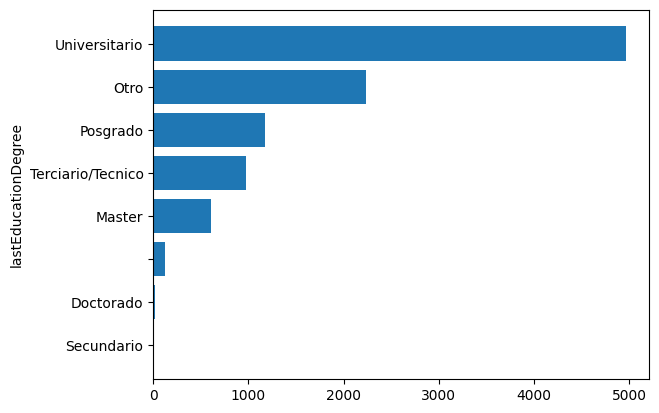

Total de valores diferentes: 50
5     1653
6     1345
4     1312
7     1157
8      876
3      668
9      589
10     469
11     336
2      290
12     251
0      200
13     186
14     127
15     107
1       92
16      83
18      58
19      51
20      49
Name: yearsOfStudy, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_12644\2838785334.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top10 = groupedData[:dataVisualizationTopLimit]


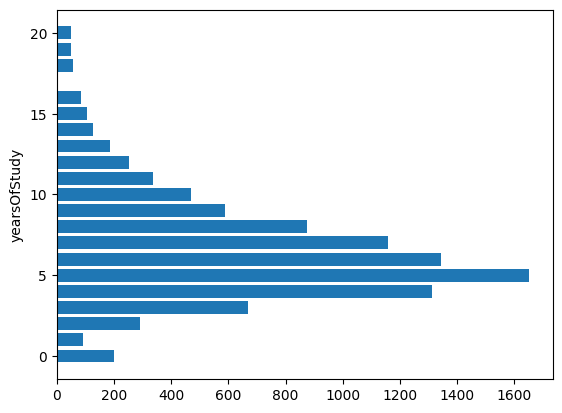

Total de valores diferentes: 39
1     3753
2     2327
3     1156
4      704
5      464
6      421
7      282
8      190
9      142
0      123
11     117
10      89
12      69
14      53
13      43
16      25
15      22
20      19
17      17
18      17
Name: studiesNumber, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_12644\2838785334.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top10 = groupedData[:dataVisualizationTopLimit]


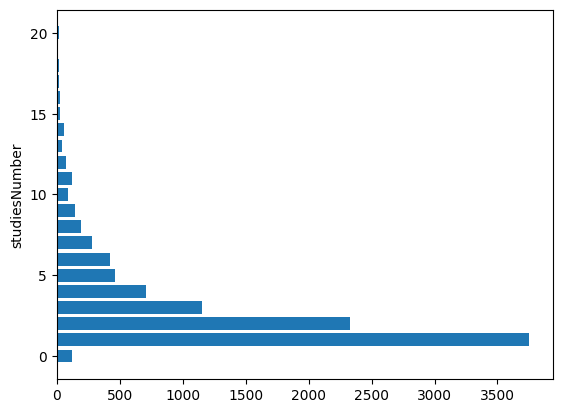

Total de valores diferentes: 68
0     1195
1     1105
3      847
2      798
4      668
5      573
6      517
7      484
9      445
8      419
11     339
10     335
12     257
13     240
16     231
14     184
15     159
17     126
18     118
21      92
Name: technicalSkills, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_12644\2838785334.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top10 = groupedData[:dataVisualizationTopLimit]


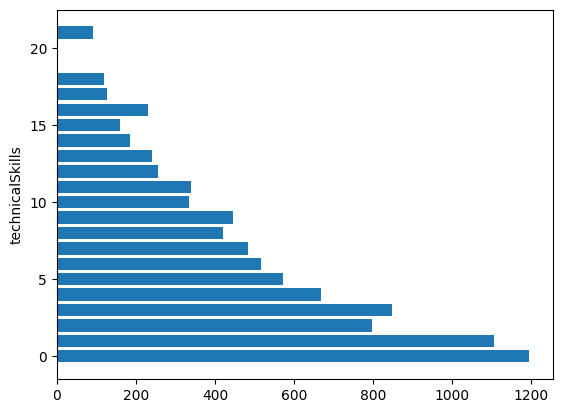

Total de valores diferentes: 6
1    7046
2    1953
0     746
3     299
4      55
5       1
Name: languages, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_12644\2838785334.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top10 = groupedData[:dataVisualizationTopLimit]


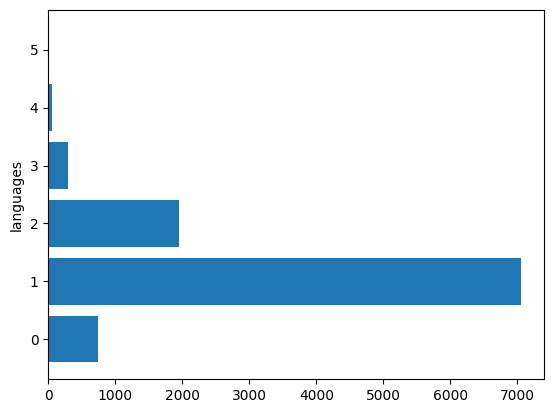

Total de valores diferentes: 46
0     2331
1     1726
2     1157
3      827
4      736
5      632
6      489
7      430
8      333
9      274
10     211
11     173
12     138
13     113
14      89
15      69
17      50
16      49
20      35
19      32
Name: otherSkills, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_12644\2838785334.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top10 = groupedData[:dataVisualizationTopLimit]


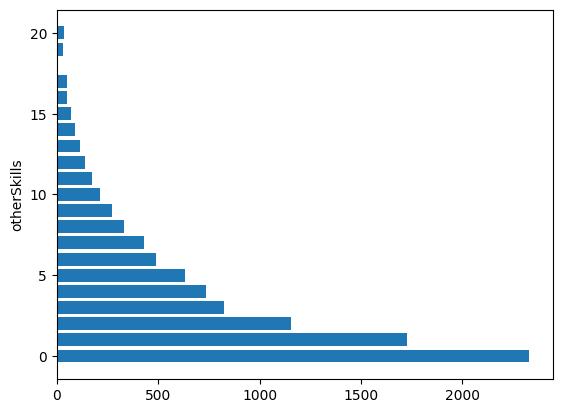

Total de valores diferentes: 2
0    9600
1     500
Name: hired, dtype: int64


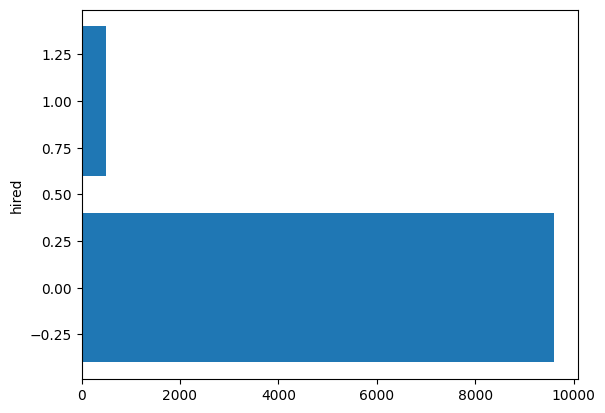

Fin: 2023-05-20 14:14:38.707733
Tiempo: 0:00:03.364063


In [36]:
if __name__ == "__main__":
  main()